In [393]:
import pandas as pd
import numpy as np

In [2]:
df_AMEX = pd.read_csv('Data/AMEX_01071962_31121999_with_out_shares.csv')
df_NYSE = pd.read_csv('Data/NYSE_01071962_31121999_with_out_shares.csv')

# Are these all common shares? Hard to tell if there are any preference shares involved. Possibly share class might say but this usually means it is common

df_AMEX_NYSE = pd.concat([df_AMEX, df_NYSE], axis=0)

/Users/jamesmcgreevy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [397]:
#there are a number of NA's where no price,volume or return data is available
df_AMEX_NYSE=df_AMEX_NYSE.dropna()

In [398]:
# Remove rows from df where return value was C
df_AMEX_NYSE = df_AMEX_NYSE[df_AMEX_NYSE['RET'] != 'C']

df_AMEX_NYSE

,PERMNO,date,EXCHCD,COMNAM,PRC,VOL,RET,SHROUT
59654,10938,1965-03-11,2,BYERS A M CO,9.875,200.0,0.006369,1323.0
59655,10938,1965-03-12,2,BYERS A M CO,9.750,400.0,-0.012658,1323.0
59656,10938,1965-03-15,2,BYERS A M CO,-9.750,0.0,0.000000,1323.0
59657,10938,1965-03-16,2,BYERS A M CO,-9.750,0.0,0.000000,1323.0
59658,10938,1965-03-17,2,BYERS A M CO,9.500,200.0,-0.025641,1323.0
...,...,...,...,...,...,...,...,...
15860751,86239,1969-12-24,1,C F & I STEEL CORP,20.000,400.0,0.006289,3892.0
15860752,86239,1969-12-26,1,C F & I STEEL CORP,20.125,200.0,0.006250,3892.0
15860753,86239,1969-12-29,1,C F & I STEEL CORP,20.500,600.0,0.018634,3892.0
15860754,86239,1969-12-30,1,C F & I STEEL CORP,20.000,1600.0,-0.024390,3892.0


In [399]:
# Do some tidying up. Create new columns for year and month
df_AMEX_NYSE['year'] = df_AMEX_NYSE['date'].apply(lambda x: x[:4])
df_AMEX_NYSE['month'] = df_AMEX_NYSE['date'].apply(lambda x: x[5:7])

# Change string values to float
df_AMEX_NYSE['PERMNO'] = df_AMEX_NYSE['PERMNO'].astype(int)
df_AMEX_NYSE['year'] = df_AMEX_NYSE['year'].astype(int)
df_AMEX_NYSE['month'] = df_AMEX_NYSE['month'].astype(int)
df_AMEX_NYSE['RET'] = df_AMEX_NYSE['RET'].astype(float)
df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].astype(float)
df_AMEX_NYSE['VOL'] = df_AMEX_NYSE['VOL'].astype(float)
df_AMEX_NYSE['SHROUT'] = df_AMEX_NYSE['SHROUT'].astype(float)

# Sort as looks nicer
df_AMEX_NYSE = df_AMEX_NYSE.sort_values(['PERMNO', 'date'])

In [400]:
df_AMEX_NYSE = df_AMEX_NYSE.set_index(['PERMNO', 'year', 'month', 'date'])

In [401]:
# Really important, from CRSP website: 'Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. 
# Instead the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used.'
# Hence we need to multiply any PRC with a dash in front by -1 to get a positive price
df_AMEX_NYSE[df_AMEX_NYSE['PRC'] <= 0]

df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].apply(lambda x: -x if x < 0 else x)

In [402]:
# Now that the prices are corrected, add column for dollar vol and market cap in millions
df_AMEX_NYSE['DOLLAR VOL'] = ((df_AMEX_NYSE['VOL'] * df_AMEX_NYSE['PRC']) / 1_000_000)
df_AMEX_NYSE['MKT CAP'] = ((df_AMEX_NYSE['PRC'] * df_AMEX_NYSE['SHROUT']) / 1_000_000)

In [403]:
df_AMEX_NYSE

EXCHCD                COMNAM     PRC     VOL  \
PERMNO year month date                                                       
10006  1962 7     1962-07-02       1  A C F INDUSTRIES INC  62.000  1700.0   
                  1962-07-03       1  A C F INDUSTRIES INC  61.125  2800.0   
                  1962-07-05       1  A C F INDUSTRIES INC  61.000  2200.0   
                  1962-07-06       1  A C F INDUSTRIES INC  60.500  2300.0   
                  1962-07-09       1  A C F INDUSTRIES INC  61.000   900.0   
...                              ...                   ...     ...     ...   
86239  1969 12    1969-12-24       1    C F & I STEEL CORP  20.000   400.0   
                  1969-12-26       1    C F & I STEEL CORP  20.125   200.0   
                  1969-12-29       1    C F & I STEEL CORP  20.500   600.0   
                  1969-12-30       1    C F & I STEEL CORP  20.000  1600.0   
                  1969-12-31       1    C F & I STEEL CORP  19.875  2000.0   

                                   RET  SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month date                                                
10006  1962 7     1962-07-02  0.050847  1453.0    0.105400  0.090086  
                  1962-07-03 -0.014113  1453.0    0.171150  0.088815  
                  1962-07-05 -0.002045  1453.0    0.134200  0.088633  
                  1962-07-06 -0.008197  1453.0    0.139150  0.087906  
                  1962-07-09  0.008264  1453.0    0.054900  0.088633  
...                                ...     ...         ...       ...  
86239  1969 12    1969-12-24  0.006289  3892.0    0.008000  0.077840  
                  1969-12-26  0.006250  3892.0    0.004025  0.078326  
                  1969-12-29  0.018634  3892.0    0.012300  0.079786  
                  1969-12-30 -0.024390  3892.0    0.032000  0.077840  
                  1969-12-31 -0.006250  3965.0    0.039750  0.078804  

[4009920 rows x 8 columns]

In [404]:
# At this point we have one dataframe: our original df_AMEX_NYSE df
# Here we diverge as the market portfolio and illiquidity portfolios require different conditions on their respective stocks, and different measures of illiquidity
# We start with the market portfolios

In [405]:
# Make a copy of df_AMEX_NYSE to maintain its integrity
df_AMEX_NYSE_market = df_AMEX_NYSE

In [406]:
# We remove any stock with beginning of the month price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year, month))

# We drop them from our main dataframe. This will help us form the market portfolio shortly
index_names = df_AMEX_NYSE_market.index.names[:3]
df_AMEX_NYSE_market = df_AMEX_NYSE_market.reset_index().set_index(index_names)
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_on_price)

In [407]:
# This is ok since the price at the start of the month was in fact 877
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] >= 1000]

# This is ok since the price at the start of the month was in fact above 5 (double check)
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] <= 5]

date  EXCHCD              COMNAM    PRC      VOL  \
PERMNO year month                                                           
10014  1966 5      1966-05-16       1  A J INDUSTRIES INC  4.750  36000.0   
            5      1966-05-17       1  A J INDUSTRIES INC  4.625  26300.0   
            5      1966-05-18       1  A J INDUSTRIES INC  5.000  17100.0   
            8      1966-08-11       1  A J INDUSTRIES INC  5.000   3600.0   
            8      1966-08-12       1  A J INDUSTRIES INC  5.000  10500.0   
...                       ...     ...                 ...    ...      ...   
84911  1966 3      1966-03-28       2          STEPHAN CO  5.000    600.0   
            3      1966-03-29       2          STEPHAN CO  4.875   1500.0   
            3      1966-03-30       2          STEPHAN CO  5.000    100.0   
            3      1966-03-31       2          STEPHAN CO  4.875    100.0   
       1967 9      1967-09-15       2          STEPHAN CO  5.000    600.0   

                        RET  SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month                                          
10014  1966 5     -0.116279  3369.0    0.171000  0.016003  
            5     -0.026316  3369.0    0.121637  0.015582  
            5      0.081081  3369.0    0.085500  0.016845  
            8     -0.024390  3369.0    0.018000  0.016845  
            8      0.000000  3369.0    0.052500  0.016845  
...                     ...     ...         ...       ...  
84911  1966 3      0.000000   364.0    0.003000  0.001820  
            3     -0.025000   364.0    0.007313  0.001775  
            3      0.025641   364.0    0.000500  0.001820  
            3     -0.025000   364.0    0.000487  0.001775  
       1967 9     -0.024390   364.0    0.003000  0.001820  

[24602 rows x 9 columns]

In [408]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# The paper only uses stocks for which they have at least 15 days per month of valid values
rows_to_delete_too_few_obs = []

for (name, year, month) in df_valid_obs_days.index:
    #print((name, year, month))
    #print(df_valid_obs_days.loc[(name, year, month)])
    if (df_valid_obs_days.loc[(name, year, month)] < 15):
        rows_to_delete_too_few_obs.append((name, year, month))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_too_few_obs)

In [409]:
# Now find illiquidity of each stock
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_market['RET']) / df_AMEX_NYSE_market['DOLLAR VOL']
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()

ILLIQUIDITY
PERMNO year month             
10006  1962 7         5.472508
            8         2.486218
            9         1.918960
            10        1.932039
            11        1.598859
...                        ...
86239  1969 8        10.724778
            9         8.830032
            10       19.983544
            11       16.214974
            12       29.183556

[176390 rows x 1 columns]

In [410]:
# We can now compute illiquidity values for each stock for each month of each year
df_illiquidity_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_market = df_illiquidity_market.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()
df_illiquidity_market = df_illiquidity_market.rename(columns={0: 'ILLIQUIDITY'})
df_illiquidity_market['ILLIQ VAR'] = df_illiquidity_var['ILLIQUIDITY']
'''df_illiquidity_market['CAP'] = df_AMEX_NYSE_market['MKT CAP']'''

"df_illiquidity_market['CAP'] = df_AMEX_NYSE_market['MKT CAP']"

In [411]:
# We need to find the return of the market portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE.columns)
df_AMEX_NYSE_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE.columns)

In [412]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_caps.index, names=['PERMNO', 'year', 'month'])

In [413]:
# We get the returns of our market portfolios for each month of each year
df_AMEX_NYSE_monthly_portfolios = df_AMEX_NYSE_monthly_prices.groupby(['year', 'month'])

monthly_portfolio_returns = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios:
    new_index.append((year, month))
    col = group['MONTHLY RETURNS']
    L = len(col)
    ret = col.values/L
    ret = np.nansum(ret, axis=0)
    monthly_portfolio_returns.append(ret)

df_AMEX_NYSE_monthly_portfolio_returns = pd.DataFrame(monthly_portfolio_returns, index=new_index, columns=['RET'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolio_returns.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_returns.index, names=['year', 'month'])

In [414]:
# Now we get monthly market cap ratios as defined in the paper, assumed equal weight
df_AMEX_NYSE_monthly_portfolio_caps = df_AMEX_NYSE_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    #cap = col.values/col.sum()
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [415]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_caps.index, names=['year', 'month'])

# We now need the cap ratios to the cap of July 1962
base = df_AMEX_NYSE_monthly_portfolio_caps.loc[(1962, 7), 'CAP']

# We compute the ratio of the current market cap to that of July 1962
df_AMEX_NYSE_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_monthly_portfolio_caps['CAP'] / base

In [419]:
# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe
# We wont be working with the returns and c from 1962, so its ok for its values in July to be incorrect
# This is super slow

df_illiquidity_market['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_illiquidity_market))

for index in df_illiquidity_market.index:
    pos = index[1:3]

    if (pos == (1962, 7)):
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_monthly_portfolio_caps.iloc[i - 1, 1]
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY'] * ratio


In [421]:
# Now we can compute c
df_illiquidity_market['c'] = np.minimum(0.25 + 0.3 * df_illiquidity_market['ADJUSTED ILLIQUIDITY'], 30.)

# Save the file
#df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv')'''

# Takes a long time so just read in instead
#df_illiquidity_market = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv', index_col=['PERMNO', 'year', 'month'])

In [422]:
'''df_illiquidity_market = pd.merge(df_illiquidity_market, df_AMEX_NYSE_market['MKT CAP'].to_frame(), left_index=True, right_index=True)'''
df_illiquidity_market = df_illiquidity_market.join(df_AMEX_NYSE_monthly_caps['MKT CAP'], on=['PERMNO', 'year', 'month'])

In [423]:
# Now we can find the illiquidity for each market portfolio for each month of each year
df_AMEX_NYSE_monthly_portfolios_illiquidity = df_illiquidity_market.groupby(['year', 'month'])

monthly_portfolio_illiquidity = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios_illiquidity:
    new_index.append((year, month))
    col = group['c']
    L = len(col)
    c = col.values/L
    c = np.nansum(c, axis=0)
    monthly_portfolio_illiquidity.append(c)

df_AMEX_NYSE_monthly_portfolios_illiquidity = pd.DataFrame(monthly_portfolio_illiquidity, index=new_index, columns=['c'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolios_illiquidity.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolios_illiquidity.index, names=['year', 'month'])

In [424]:
# We combine the market portfolios values into one dataframe
df_AMEX_NYSE_monthly_portfolio_returns['c'] = df_AMEX_NYSE_monthly_portfolios_illiquidity['c']
df_AMEX_NYSE_market_portfolios = df_AMEX_NYSE_monthly_portfolio_returns
df_AMEX_NYSE_market_portfolios

RET         c
year month                    
1962 7      0.000000  1.009866
     8      0.042890  0.935297
     9      0.024340  1.020853
     10    -0.068150  0.992205
     11    -0.014674  0.883115
...              ...       ...
1969 8     -0.082069  0.750471
     9      0.017093  0.746877
     10    -0.030096  0.651767
     11     0.092075  0.667409
     12    -0.067297  0.681837

[90 rows x 2 columns]

In [425]:
df_illiquidity_market

ILLIQUIDITY  ILLIQ VAR  ADJUSTED ILLIQUIDITY         c  \
PERMNO year month                                                           
10006  1962 7         0.260596   0.083900              0.260596  0.328179   
            8         0.108096   0.033402              0.108096  0.282429   
            9         0.100998   0.007189              0.102397  0.280719   
            10        0.084002   0.005918              0.079799  0.273940   
            11        0.079943   0.004356              0.077409  0.273223   
...                        ...        ...                   ...       ...   
86239  1969 8         0.510704   0.383975              0.734314  0.470294   
            9         0.420478   0.218495              0.632538  0.439761   
            10        0.868850   0.730725              1.276010  0.632803   
            11        0.853420   1.368968              1.319949  0.645985   
            12        1.326525   3.795167              1.958656  0.837597   

                    MKT CAP  
PERMNO year month            
10006  1962 7      0.098077  
            8      0.097533  
            9      0.092266  
            10     0.098804  
            11     0.105887  
...                     ...  
86239  1969 8      0.091462  
            9      0.086597  
            10     0.085138  
            11     0.077840  
            12     0.078804  

[176390 rows x 5 columns]

In [426]:
df_AMEX_NYSE_monthly_portfolio_caps

CAP     RATIO
year month                    
1962 7      0.192990  1.000000
     8      0.195665  1.013856
     9      0.183334  0.949964
     10     0.186874  0.968308
     11     0.209385  1.084952
...              ...       ...
1969 8      0.290322  1.504332
     9      0.283430  1.468620
     10     0.298490  1.546659
     11     0.284956  1.476531
     12     0.285444  1.479057

[90 rows x 2 columns]

In [427]:
df_AMEX_NYSE_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_monthly_portfolio_caps['RATIO'].shift(1))

df_illiquidity_market_grouped = df_illiquidity_market.groupby(['year', 'month'])
monthly_market_portfolio_unnormalized_illiq = []
new_index = []

for (year, month), group in df_illiquidity_market_grouped:
    new_index.append((year, month))
    
    # Get the illiq of the market portfolio for each month
    illiquidities = group['ILLIQUIDITY']
    caps = group['MKT CAP']
    L = len(illiquidities)
    #print(L)

    # Get the adjusted ratio of the respective month
    adjusted_ratio = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
    #total_cap = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'CAP']
    #total_cap = caps.sum()
    adjusted_ratio_arr = np.ones(L) * adjusted_ratio

    #w = caps / total_cap

    # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
    unnormalized_illiquidities = np.minimum(illiquidities.values, adjusted_ratio_arr)
    
    # This is for value weights
    #illiq = illiquidities * w
    
    # This is for equal weights
    illiq = illiquidities/L
    illiq = np.nansum(illiq, axis=0)
    monthly_market_portfolio_unnormalized_illiq.append(illiq)

df_AMEX_NYSE_monthly_portfolio_caps['ILLIQ_bar'] = monthly_market_portfolio_unnormalized_illiq

In [428]:
df_AMEX_NYSE_monthly_portfolio_caps

CAP     RATIO  ADJUSTED RATIO  ILLIQ_bar
year month                                               
1962 7      0.192990  1.000000             NaN   2.613312
     8      0.195665  1.013856       99.166667   2.300433
     9      0.183334  0.949964       97.811404   2.615498
     10     0.186874  0.968308      104.389898   2.644982
     11     0.209385  1.084952      102.412297   2.215849
...              ...       ...             ...        ...
1969 8      0.290322  1.504332       68.968835   1.160233
     9      0.283430  1.468620       65.920717   1.100992
     10     0.298490  1.546659       67.523725   0.911894
     11     0.284956  1.476531       64.116697   0.899592
     12     0.285444  1.479057       67.161922   0.974890

[90 rows x 4 columns]

In [429]:
def residual_c(df):
    #Now perform regression

    #temp name for easy of reading
    x=df

    y=0.25+0.3*x['ILLIQ_bar']*x['RATIO']#.shift(1)
    x1=0.25+0.3*x['ILLIQ_bar'].shift(1)*x['RATIO'].shift(1)
    x2=0.25+0.3*x['ILLIQ_bar'].shift(2)*x['RATIO'].shift(1)

    y=y[2:] #remove observation with NA's in X

    #now do regression
    #(XTX)^-1(xTY)
    x0=np.ones(x1.shape)
    xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
    xs['x1']=x1
    xs['x2']=x2

    xs=xs.dropna()

    coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

    #Now estimate residuals

    xs['y_hat']=(xs*coefs).sum(axis=1)
    xs['resid']=y-xs['y_hat']

    return xs

In [430]:
market_regression_residual = residual_c(df_AMEX_NYSE_monthly_portfolio_caps)

In [431]:
market_regression_residual[16:]

x0        x1        x2     y_hat     resid
year month                                             
1964 1      1.0  0.803152  0.845128  0.788371  0.064812
     2      1.0  0.853182  0.819055  0.846237 -0.006466
     3      1.0  0.839771  0.857773  0.825887 -0.001774
     4      1.0  0.824113  0.844450  0.811052 -0.011339
     5      1.0  0.799713  0.825137  0.787714  0.067401
...         ...       ...       ...       ...       ...
1969 8      1.0  0.716817  0.568814  0.737506  0.036106
     9      1.0  0.773613  0.738403  0.772825 -0.037744
     10     1.0  0.735082  0.761182  0.727847 -0.054730
     11     1.0  0.673116  0.760858  0.661149 -0.012667
     12     1.0  0.648483  0.653932  0.650919  0.031656

[72 rows x 5 columns]

<AxesSubplot:xlabel='year,month'>

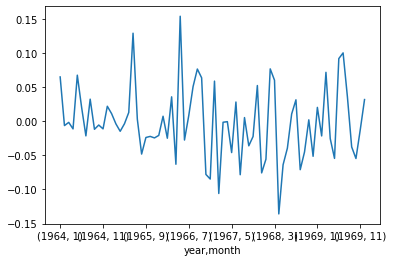

In [432]:
vals = market_regression_residual['resid'].loc[(1964, 1):]
vals.plot()

In [433]:
def residual_returns(df):
    regression_data=df.groupby(['year','month']).sum()
    #perform regression on market portfolio against itself one period earlier
    y=regression_data['RET']
    x1=regression_data['RET'].shift(1)
    x2=regression_data['RET'].shift(2)

    y=y[2:] 

    #now do regression
    #(XTX)^-1(xTY)
    x0=np.ones(x1.shape)
    xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
    xs['x1']=x1
    xs['x2']=x2

    xs=xs.dropna()

    coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

    #Now estimate residuals

    xs['y_hat']=(xs*coefs).sum(axis=1)
    xs['resid']=y-xs['y_hat']

    return xs

    #missing last entry as this would require knowing the future market value I think

In [435]:
def residual_returns(df):
    regression_data=df.groupby(['year','month']).sum()
    #perform regression on market portfolio against itself one period earlier
    x1=regression_data['RET'].shift(1)[1:].to_frame()
    y=regression_data['RET'][1:]

    #capm assumes intercept is 0
    #consider as regressing y=r_t-1 on x=r_t-2 to avoid bias

    coefs=np.linalg.inv(x1.T@x1).dot(np.dot(x1.T,y)).T

    #now estimate residuals
    # r_t vs E_t-1[r_t]
    x1['y_hat']=x1*coefs #E_t-1[r_t]=B*r_t-1
    x1['resid']=y.shift(-1)-x1['y_hat'] #r_t-b*r_t-1
    market_portfolio_regression=x1

    return market_portfolio_regression

    #missing last entry as this would require knowing the future market value I think'''

In [436]:
market_portfolio_regression=residual_returns(df_AMEX_NYSE_market_portfolios)

In [437]:
market_portfolio_regression

RET     y_hat     resid
year month                              
1962 8      0.000000  0.000000  0.024340
     9      0.042890  0.006908 -0.075058
     10     0.024340  0.003920 -0.018594
     11    -0.068150 -0.010976  0.115226
     12    -0.014674 -0.002363 -0.007488
...              ...       ...       ...
1969 8     -0.112599 -0.018134  0.035228
     9     -0.082069 -0.013218 -0.016879
     10     0.017093  0.002753  0.089322
     11    -0.030096 -0.004847 -0.062450
     12     0.092075  0.014829       NaN

[89 rows x 3 columns]

In [39]:
# Now we move on to our illiquidity sorted portfolios. For now lets just do the portfolio sorted by illiquidity value rather than it and the variance and cap sorted portfolios

In [438]:
# Again, copy our new dataframe to maintain its integrity
df_AMEX_NYSE_non_market = df_AMEX_NYSE

In [439]:
# We are only working with data from 1963 now so we drop any data from 1962
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(1962, level=1)

In [440]:
# We remove any stock with beginning of the year price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year))

# We drop them from our main dataframe. This will help us form the new portfolios shortly
index_names = df_AMEX_NYSE_non_market.index.names[:2]
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(index_names)
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(index=rows_to_delete_on_price)

In [441]:
# We return the market caps as we will need them shortly for portfolio sorting. This time the caps are based on yearly caps
AMEX_NYSE_yearly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    new_index.append((name, year))
    AMEX_NYSE_yearly_caps.append(row_one)

df_AMEX_NYSE_non_market_yearly_caps = pd.DataFrame(AMEX_NYSE_yearly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [442]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_yearly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_yearly_caps.index, names=['PERMNO', 'year'])

In [443]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year'])['date'].count()
df_valid_obs_days.to_frame()

# Now find annual illiquidity of all stocks
# Begin by finding daily illquidity of all stocks

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_non_market['RET']) / df_AMEX_NYSE_non_market['DOLLAR VOL']
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid year
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()

In [444]:
# We can now compute illiquidity values for each stock for each year
df_illiquidity_non_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_non_market = df_illiquidity_non_market.to_frame()
df_illiquidity_non_market = df_illiquidity_non_market.rename(columns={0: 'ILLIQUIDITY'})

# Each year's liquidity value is actually the previous full year's, as we are sorting based on year t - 1, so we shift the dataframe
df_illiquidity_non_market = df_illiquidity_non_market.shift()
df_illiquidity_non_market_var = df_illiquidity_var.shift()

In [445]:
# The paper only uses stocks for which they have at least 100 days in the last year of valid values
rows_to_delete_too_few_obs = []

for (name, year) in df_valid_obs_days.index:
    current_row_num = df_valid_obs_days.index.get_loc((name, year))
    if (current_row_num == 0):
        rows_to_delete_too_few_obs.append((name, year))
    else:
        row_num_minus_one = current_row_num - 1
        row_num_minus_one_name = df_valid_obs_days.index[row_num_minus_one][0]
        row_num_minus_one_days = df_valid_obs_days.iloc[row_num_minus_one]

        if (name == row_num_minus_one_name):
            if (row_num_minus_one_days < 100):
                rows_to_delete_too_few_obs.append((name, year))
        else:
            rows_to_delete_too_few_obs.append((name, year))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_illiquidity_non_market = df_illiquidity_non_market.drop(index=rows_to_delete_too_few_obs)
df_illiquidity_non_market_var = df_illiquidity_non_market_var.drop(index=rows_to_delete_too_few_obs)

In [446]:
df_illiquidity_non_market #this is yearly illiquidity, we also need monthly now

ILLIQUIDITY
PERMNO year             
10006  1964     0.093710
       1965     0.065199
       1966     0.042041
       1967     0.060421
       1968     0.055124
...                  ...
86239  1965     0.154804
       1966     0.110522
       1967     0.204352
       1968     0.097215
       1969     0.114312

[11217 rows x 1 columns]

In [447]:
# Group the dataframe by years
df_illiquidity_non_market_year_group = df_illiquidity_non_market.groupby('year')
df_illiquidity_non_market_var_year_group = df_illiquidity_non_market_var.groupby('year')
df_AMEX_NYSE_non_market_yearly_caps_group = df_AMEX_NYSE_non_market_yearly_caps.groupby('year')

In [448]:
# Now we sort into the correct portfolios
# create an empty list to store the split dataframes
df_non_market_increasing_yearly_illiquidity_portfolios = []

# loop over each group
for name, group in df_illiquidity_non_market_year_group:
    # sort the group
    sorted_group = group.sort_values('ILLIQUIDITY')
    # divide the sorted group into 25 equal parts
    split_group = np.array_split(sorted_group, 25)
    # append the split group to the list of split dataframes
    df_non_market_increasing_yearly_illiquidity_portfolios += split_group

In [449]:
# We need to find the return of the portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(['PERMNO', 'year', 'month'])
df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_non_market_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE_non_market.columns)
df_AMEX_NYSE_non_market_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [450]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_caps.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_non_market_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_non_market_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

In [451]:
# We now have to repeat this proceedure for the adjusted illiquidity values c. To do this we bring over the functions used in the other ipynb. Note: the calculation for adjusted illiquidity takes a very long time

# Now we get monthly market cap ratios as defined in the paper
df_AMEX_NYSE_non_market_monthly_portfolio_caps = df_AMEX_NYSE_non_market_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_non_market_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_non_market_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [452]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_non_market_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_portfolio_caps.index, names=['year', 'month'])

In [453]:
# We now need the cap ratios to the cap of July 1962
#base = df_AMEX_NYSE_monthly_portfolio_caps.loc[('1962', '07'), 'CAP']
base = 0.19308631191927988
df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_non_market_monthly_portfolio_caps['CAP'] / base

In [454]:
# Now find market portfolio illiquidity
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_sum.to_frame()

ILLIQUIDITY
PERMNO year month             
10006  1963 1         1.051732
            2         1.152710
            3         1.406984
            4         1.942196
            5         1.524969
...                        ...
86239  1969 8        10.724778
            9         8.830032
            10       19.983544
            11       16.214974
            12       29.183556

[165135 rows x 1 columns]

In [455]:
# We can now compute illiquidity values for each stock for each month of each year
df_non_market_illiquidity = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_non_market_illiquidity = df_non_market_illiquidity.to_frame()
df_non_market_illiquidity = df_non_market_illiquidity.rename(columns={0: 'ILLIQUIDITY'})

In [457]:
# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe

df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_non_market_illiquidity))

for index in df_non_market_illiquidity.index:
    pos = index[1:3]

    if (pos == (1962, 7)):
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_non_market_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.iloc[i - 1, 1]
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY'] * ratio

# Now we can compute c
df_non_market_illiquidity['c'] = np.minimum(0.25 + 0.3 * df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'], 30.)


In [59]:
'''# Save the file
df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv')

'''# Takes a long time so just read in instead
#df_non_market_illiquidity = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv', index_col=['PERMNO', 'year', 'month'])

In [458]:
df_AMEX_NYSE_non_market_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'].shift(1))

In [459]:
# We need to compute the returns and illiquidity c values for each portfolio 
# Start with the increasing illiquidity portfolio
# The structure is dictionary with key = year and value = dictionary. This second dictionary has key = the portfolio number and value = dataframe of monthly returns
df_non_market_increasing_yearly_illiquidity_portfolios_returns = {}
i = 0

for portfolio in df_non_market_increasing_yearly_illiquidity_portfolios:
    # For each portfolio get its position in the order and year
    portfolio_number = i % 25
    portfolio_year = portfolio.index[0][1]
    
    # If this is the first portfolio make a dictionary to save the portfolio numbers and their dataframes
    if i == 0:
        dictionary_for_portfolio_year = {}
    
    # Get monthly returns and add to dictionary 
    portfolio_stocks = list(portfolio.index.get_level_values(level=0))
    portfolio_monthly_returns = df_AMEX_NYSE_non_market_monthly_prices.xs(portfolio_year, level=1)
    portfolio_monthly_returns = portfolio_monthly_returns.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_returns = portfolio_monthly_returns.groupby(['month'])
    new_index = []
    rets = []

    for (month), group in portfolio_monthly_returns:
        new_index.append(int(month))
        col = group['MONTHLY RETURNS']
        L = len(col)
        ret = col.values/L
        ret = np.nansum(ret, axis=0)
        rets.append(ret)
    
    # Do the same for mkt caps
    portfolio_monthly_caps = df_AMEX_NYSE_non_market_monthly_caps.xs(portfolio_year, level=1)
    portfolio_monthly_caps = portfolio_monthly_caps.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_caps = portfolio_monthly_caps.groupby(['month'])
    #new_index = []
    caps = []

    for (month), group in portfolio_monthly_caps:
        #new_index.append(int(month))
        col = group['MKT CAP']
        L = len(col)
        cap = col.values/L
        cap = np.nansum(cap, axis=0)
        caps.append(cap)

    # Get monthly c and add to dictionary 
    portfolio_monthly_c = df_non_market_illiquidity.xs(portfolio_year, level=1)
    portfolio_monthly_c = portfolio_monthly_c.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly c for each stock in portfolio before summing and averaging
    portfolio_monthly_c = portfolio_monthly_c.groupby(['month'])
    #new_index = []
    cs = []

    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        col = group['c']
        L = len(col)
        c = col.values/L
        c = np.nansum(c, axis=0)
        cs.append(c)
    
    #new_index = []
    bars = []
    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        adjusted_ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
        col = group['ILLIQUIDITY']
        L = len(col)
        adjusted_ratio_arr = np.ones(L) * adjusted_ratio

        # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
        unnormalized_illiquidities = np.minimum(col.values, adjusted_ratio_arr)
        bar = col.values/L
        bar = np.nansum(bar, axis=0)
        bars.append(bar)

    # We now need the cap ratios to the cap of July 1962
    #base = df_AMEX_NYSE_monthly_portfolio_caps.loc[('1962', '07'), 'CAP']
    base = 0.19308631191927988
    
    # Make a dataframe of monthly returns and add to dictionary with key of the portfolio number
    df_portfolio_for_current_year = pd.DataFrame(rets, index=new_index, columns=['RET'])
    df_portfolio_for_current_year['CAP'] = caps
    df_portfolio_for_current_year['RATIO'] = df_portfolio_for_current_year['CAP'] / base
    df_portfolio_for_current_year['c'] = cs
    df_portfolio_for_current_year['ILLIQ_bar'] = bars
    dictionary_for_portfolio_year[portfolio_number] = df_portfolio_for_current_year

    if portfolio_number == 24 and i != 0:
        # If we have reached 25 portfolios then we are in a new year again so we add the dictionary of the portfolio number : dataframe of monthly returns to the overall dictionary
        # We then start again with a new year
        df_non_market_increasing_yearly_illiquidity_portfolios_returns[int(portfolio_year)] = dictionary_for_portfolio_year
        dictionary_for_portfolio_year = {}

    i += 1


In [460]:
df_all_portfolios = pd.DataFrame.from_dict(df_non_market_increasing_yearly_illiquidity_portfolios_returns)

In [461]:
arr_of_portfolios = []

for idx in df_all_portfolios.index:
    row = (df_all_portfolios.loc[idx]).to_frame()
    columns = row.index
    df_for_row = pd.DataFrame()
    L = len(columns)
    vals = row.values
    for i in range(L):
        year = np.ones(12)*columns[i]
        df_for_val = vals[i][0]
        df_for_val = df_for_val.rename_axis('month')
        df_for_val['year'] = year
        df_for_val = df_for_val.reset_index().set_index(['year', 'month'])
        df_for_row = pd.concat([df_for_row, df_for_val])
    arr_of_portfolios.append(df_for_row)


In [462]:
market_portfolio_regression_restricted = market_portfolio_regression[17:]
market_portfolio_regression_restricted

RET     y_hat     resid
year month                              
1964 1     -0.016779 -0.002702  0.012960
     2      0.003721  0.000599  0.021639
     3      0.010257  0.001652  0.018905
     4      0.022238  0.003582 -0.009397
     5      0.020557  0.003311 -0.007903
...              ...       ...       ...
1969 8     -0.112599 -0.018134  0.035228
     9     -0.082069 -0.013218 -0.016879
     10     0.017093  0.002753  0.089322
     11    -0.030096 -0.004847 -0.062450
     12     0.092075  0.014829       NaN

[72 rows x 3 columns]

In [463]:
market_regression_residual_restricted = market_regression_residual[16:]
market_regression_residual_restricted

x0        x1        x2     y_hat     resid
year month                                             
1964 1      1.0  0.803152  0.845128  0.788371  0.064812
     2      1.0  0.853182  0.819055  0.846237 -0.006466
     3      1.0  0.839771  0.857773  0.825887 -0.001774
     4      1.0  0.824113  0.844450  0.811052 -0.011339
     5      1.0  0.799713  0.825137  0.787714  0.067401
...         ...       ...       ...       ...       ...
1969 8      1.0  0.716817  0.568814  0.737506  0.036106
     9      1.0  0.773613  0.738403  0.772825 -0.037744
     10     1.0  0.735082  0.761182  0.727847 -0.054730
     11     1.0  0.673116  0.760858  0.661149 -0.012667
     12     1.0  0.648483  0.653932  0.650919  0.031656

[72 rows x 5 columns]

In [464]:
arr_of_residual_c = []
market_portfolio_regression_restricted = market_portfolio_regression[17:]
market_regression_residual_restricted = market_regression_residual[16:]

for portfolio in arr_of_portfolios:
    df_residual_c = residual_c(portfolio)
    portfolio['resid_c'] = df_residual_c['resid']
    portfolio['resid_market_ret'] = market_portfolio_regression_restricted['resid']
    portfolio['resid_market_c'] = market_regression_residual_restricted['resid']
    portfolio['resid_market_ret_c_diff'] = portfolio['resid_market_ret'] - portfolio['resid_market_c']
    arr_of_residual_c.append(df_residual_c)

In [465]:
arr_of_portfolios[0]

RET       CAP      RATIO         c  ILLIQ_bar   resid_c  \
year   month                                                                 
1964.0 1      0.016104  3.172536  16.430662  0.254995   0.013318       NaN   
       2     -0.013964  3.216404  16.657859  0.255084   0.013237       NaN   
       3      0.012111  3.258614  16.876465  0.255031   0.012941 -0.004605   
       4     -0.001761  3.288644  17.031991  0.257233   0.018327  0.023918   
       5      0.007045  3.333760  17.265649  0.256673   0.016843 -0.002631   
...                ...       ...        ...       ...        ...       ...   
1969.0 8     -0.061135  3.607901  18.685429  0.266424   0.038639  0.058944   
       9      0.021468  3.494333  18.097258  0.261680   0.026347 -0.049911   
       10    -0.040250  3.619034  18.743090  0.262254   0.028405  0.017557   
       11     0.058044  3.506144  18.158429  0.262566   0.027686  0.003821   
       12    -0.056808  3.509884  18.177800  0.264329   0.032843  0.037742   

              resid_market_ret  resid_market_c  resid_market_ret_c_diff  
year   month                                                             
1964.0 1              0.012960        0.064812                -0.051852  
       2              0.021639       -0.006466                 0.028105  
       3              0.018905       -0.001774                 0.020679  
       4             -0.009397       -0.011339                 0.001942  
       5             -0.007903        0.067401                -0.075305  
...                        ...             ...                      ...  
1969.0 8              0.035228        0.036106                -0.000879  
       9             -0.016879       -0.037744                 0.020865  
       10             0.089322       -0.054730                 0.144053  
       11            -0.062450       -0.012667                -0.049783  
       12                  NaN        0.031656                      NaN  

[72 rows x 9 columns]

In [466]:
betas = []

for portfolio in arr_of_portfolios:
    denominator = portfolio['resid_market_ret_c_diff'].var()
    beta_1 = (portfolio['RET'].cov(portfolio['resid_market_ret'])) / denominator
    beta_2 = (portfolio['resid_c'].cov(portfolio['resid_market_c'])) / denominator
    beta_3 = (portfolio['RET'].cov(portfolio['resid_market_c'])) / denominator
    beta_4 = (portfolio['resid_c'].cov(portfolio['resid_market_ret'])) / denominator

    betas.append([beta_1, beta_2, beta_3, beta_4])

df_of_betas = pd.DataFrame(betas, columns=['beta_1', 'beta_2', 'beta_3', 'beta_4'])

In [467]:
df_of_betas

,beta_1,beta_2,beta_3,beta_4
0,0.055082,0.053881,-0.160056,-0.053424
1,0.046279,0.024978,-0.161254,-0.017361
2,0.050318,0.035529,-0.157362,-0.021743
3,0.064909,0.028290,-0.164435,-0.017994
4,0.062040,0.040457,-0.174455,-0.025192
5,0.072750,0.043488,-0.184143,-0.033020
6,0.049760,0.041773,-0.162198,-0.026609
7,0.050164,0.039780,-0.160863,-0.024840
8,0.046313,0.056496,-0.165456,-0.016199
9,0.047829,0.044718,-0.171113,-0.026999


<AxesSubplot:>

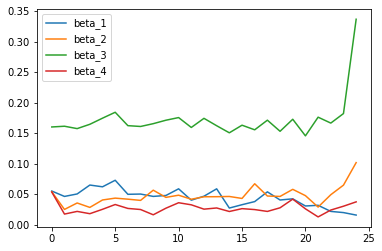

In [468]:
df_of_betas.abs().plot()

In [469]:
# We need the average illiquidity for each portfoilio in each year. Then we will use these averages per year to calculate an average for the entire period of 1964-1999 for each portfolio
df_non_market_for_portfolio_average = pd.DataFrame()
portfolio_numbers = list(range(0, 25))

for year in df_non_market_increasing_yearly_illiquidity_portfolios_returns:
    current_year_dictionary = df_non_market_increasing_yearly_illiquidity_portfolios_returns[year]
    current_year_array = np.ones(25)*year
    current_year_values_c = []
    current_year_values_ret = []

    for num in current_year_dictionary:
        current_year_num_portfolio = current_year_dictionary[num]
        average_c = current_year_num_portfolio['c'].mean()
        average_ret = current_year_num_portfolio['RET'].mean()
        current_year_values_c.append(average_c)
        current_year_values_ret.append(average_ret)

    df_for_current_year_portfolio_average = pd.DataFrame(current_year_values_c, columns=['average c'])
    df_for_current_year_portfolio_average['average RET'] = current_year_values_ret
    df_for_current_year_portfolio_average['year'] = current_year_array
    df_for_current_year_portfolio_average['number'] = portfolio_numbers
    df_for_current_year_portfolio_average = df_for_current_year_portfolio_average.set_index(['year', 'number'])

    df_non_market_for_portfolio_average = pd.concat([df_non_market_for_portfolio_average, df_for_current_year_portfolio_average], axis=0, join='outer')

        

In [470]:
df_non_market_for_portfolio_average

average c  average RET
year   number                        
1964.0 0        0.257406     0.001862
       1        0.262858     0.005389
       2        0.268393     0.004823
       3        0.277740     0.007538
       4        0.289413     0.005252
...                  ...          ...
1969.0 20       0.876660    -0.019721
       21       1.050311    -0.027622
       22       1.216514    -0.019005
       23       1.397034    -0.015969
       24       2.268372     0.001719

[150 rows x 2 columns]

In [471]:
df_non_market_for_portfolio_average_grouped = df_non_market_for_portfolio_average.groupby(['number'])
overall_portfolio_average_values_c = []
overall_portfolio_average_values_ret = []

for number, group in df_non_market_for_portfolio_average_grouped:
    col_c = group['average c']
    col_ret = group['average RET']
    average_c = col_c.mean()
    average_ret = col_ret.mean()
    overall_portfolio_average_values_c.append(average_c)
    overall_portfolio_average_values_ret.append(average_ret)

df_non_market_overall_portfolio_average = pd.DataFrame(overall_portfolio_average_values_c, index=list(range(0, 25)), columns=['average c'])
df_non_market_overall_portfolio_average['average RET'] = overall_portfolio_average_values_ret

In [472]:
df_non_market_overall_portfolio_average

,average c,average RET
0,0.256572,-0.001574
1,0.262304,0.000035
2,0.268965,0.001167
3,0.276001,0.000944
4,0.286660,0.002542
5,0.300378,0.003098
6,0.312338,0.002278
7,0.326358,0.002880
8,0.348001,0.004914
9,0.360094,0.006006


### Calculating t-statistics

In [601]:
#http://reliawiki.org/index.php/Multiple_Linear_Regression_Analysis#Example_2
lambdas=df_AMEX_NYSE_market_portfolios['RET']-df_AMEX_NYSE_market_portfolios['c']
lambdas=lambdas.loc[1964:]
t_stats=np.zeros([25,4]) 
mse=np.zeros(25)
for i in range(0,25):
    portfolio=arr_of_portfolios[i]
    beta_i=df_of_betas.iloc[i]
    y=portfolio['RET']-portfolio['c']
    
    y_hat=lambdas*(beta_i[0]+beta_i[1]-beta_i[2]-beta_i[3])
    n=len(y_hat)
    mse[i]=np.sum((y_hat-y)**2)/(n-5)
    std_err=np.sqrt(mse[i]/np.sum(lambdas**2))
    std_err=np.repeat(std_err,4)
    t_stats[i,:]=np.divide(beta_i,std_err)

In [602]:
dof=n-5
print(dof)
t_stats
#critical value at 95% for two tail test with these degrees of freedom is +-1.1.996008
#outside this region reject null hypothesis that the given beta is 0

67


array([[  4.50564972,   4.40741188, -13.09229838,  -4.3699812 ],
       [  2.50251238,   1.35069402,  -8.71976737,  -0.93880533],
       [  2.81910988,   1.9905568 ,  -8.81641673,  -1.21817143],
       [  3.64064072,   1.58674141,  -9.22291402,  -1.00923416],
       [  3.72679627,   2.43031904, -10.47974689,  -1.51331124],
       [  4.54782959,   2.71856578, -11.51128508,  -2.06418162],
       [  2.14687897,   1.80228953,  -6.99800149,  -1.14804341],
       [  1.94454471,   1.54203354,  -6.23568076,  -0.9629023 ],
       [  1.62477445,   1.98199999,  -5.80456083,  -0.56830918],
       [  1.62409398,   1.51844774,  -5.81035716,  -0.91678404],
       [  1.90595181,   1.56654403,  -5.69207286,  -1.1660299 ],
       [  1.01919413,   1.05794494,  -4.04278674,  -0.82602908],
       [  1.11818059,   1.09600618,  -4.17768582,  -0.60986108],
       [  1.24909799,   0.97495697,  -3.44794832,  -0.58223988],
       [  0.43746726,   0.74233588,  -2.41774112,  -0.34698654],
       [  0.49729738,   0

<AxesSubplot:title={'center':'Plot of MSE values by portfolio'}>

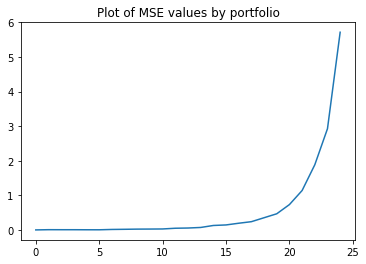

In [611]:
pd.DataFrame(mse).plot(title='Plot of MSE values by portfolio',legend=False)